# Resume Parsing

So basically, we want to create a entity ruler to parse real resume and get the "skills".

But for your assignment, i will ask you to extract education.

## 1. Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("../data/resume.csv")

In [2]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [3]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "../data/skills.jsonl"

2023-02-02 13:57:19.176643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [5]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(deep learning,)

## 3. Let's try to extract skills from this resume.csv

In [6]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
861,26459032,EXECUTIVE ASSISTANT/OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS
1275,33542483,DIGITAL CONTENT EDITOR Summary ...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA
1990,88859947,LEAD CONSTRUCTION MANAGER / REGIONAL ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
779,26695839,COMMISSION SPECIALIST Skills ...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE
380,22551979,TEACHER Summary Energetic w...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER


In [7]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [8]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         PUBLIC RELATIONS/SOCIAL MEDIA MANAGEMENT       Summary    Public Relations Manager with strong communications, event planning, media relations and social media experience within consumer brands. Solid experience establishing excellent media contacts within the beauty, fashion, and technolog'

In [9]:
preprocessing(random_resume[:300])

'public relations social media management summary public relations manager strong communication event planning medium relation social medium experience consumer brand solid experience establish excellent medium contact beauty fashion technolog'

In [10]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [11]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
861,26459032,EXECUTIVE ASSISTANT/OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS,executive assistant office manager summary con...
1275,33542483,DIGITAL CONTENT EDITOR Summary ...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA,digital content editor summary i devoted write...
1990,88859947,LEAD CONSTRUCTION MANAGER / REGIONAL ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,lead construction manager regional quality man...
779,26695839,COMMISSION SPECIALIST Skills ...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,commission specialist skills business administ...
380,22551979,TEACHER Summary Energetic w...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,teacher summary energetic year experience high...


## 4. Let's really extract skills!!

In [12]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [13]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
861,26459032,EXECUTIVE ASSISTANT/OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS,executive assistant office manager summary con...


In [14]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [15]:
df_resume.Skills.iloc[0]

['advertising',
 'schedule',
 'engineering',
 'database',
 'marketing',
 'interaction',
 'documentation']

## 5. Visualization

Which skills is most important in information management?

In [16]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [17]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(54, 6)

In [19]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [22]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [23]:
counting

OrderedDict([('support', 48),
             ('software', 44),
             ('business', 41),
             ('design', 40),
             ('server', 34),
             ('security', 34),
             ('windows', 32),
             ('database', 26),
             ('project management', 22),
             ('deployment', 20)])

<BarContainer object of 10 artists>

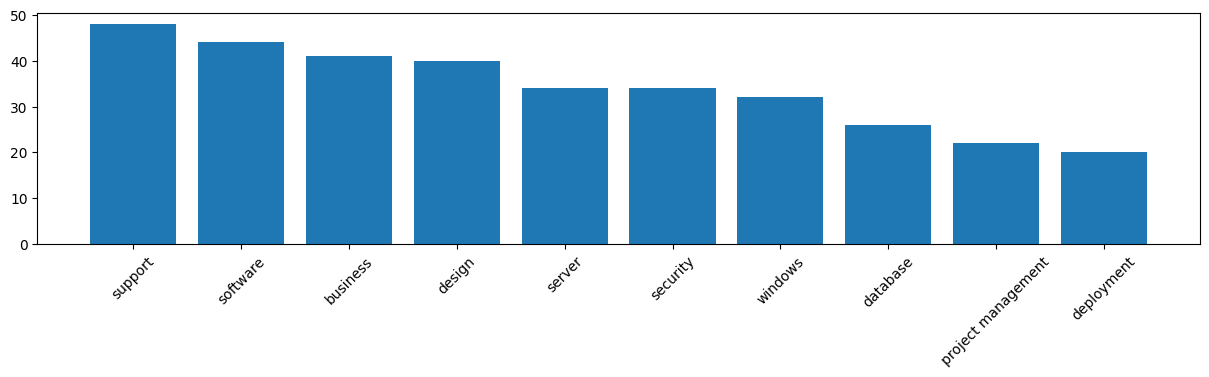

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [28]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [29]:
doc = nlp(text)

In [34]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [32]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

## 7. Let's load the PDF - add some realism

In [43]:
from PyPDF2 import PdfReader
#pip install PyPDF2

reader = PdfReader("../data/word2vec.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [44]:
text = preprocessing(text)

In [45]:
doc = nlp(text)

In [46]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [47]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

{'complex system', 'nlp', 'speech recognition', 'language model'}
